# Import

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
import numpy as np
import matplotlib.pyplot as plt
import logging
import shap

# Dataframes

In [17]:
"""
We convert the data into float32 because PyTorch expects float 32 values
- Compatibility with DL
- Memory Efficiency
- Prevent errors in training (backpropagation etc)
"""
# Define subfolder
subfolder = "01_GAN"

# Load CSV files into corresponding variables
X_external = pd.read_csv(f"CSV/Import/{subfolder}/X_external.csv").astype('float32')
y_external = pd.read_csv(f"CSV/Import/{subfolder}/y_external.csv").values.ravel().astype('float32')
X_train = pd.read_csv(f"CSV/Import/{subfolder}/X_train.csv").astype('float32')
y_train = pd.read_csv(f"CSV/Import/{subfolder}/y_train.csv").values.ravel().astype('float32')
X_validate = pd.read_csv(f"CSV/Import/{subfolder}/X_validate.csv").astype('float32')
y_validate = pd.read_csv(f"CSV/Import/{subfolder}/y_validate.csv").values.ravel().astype('float32')
X_test = pd.read_csv(f"CSV/Import/{subfolder}/X_test.csv").astype('float32')
y_test = pd.read_csv(f"CSV/Import/{subfolder}/y_test.csv").values.ravel().astype('float32')

In [18]:
"""
All computations in PyTorch are performed by the use of tensors
and not with pandas dataframes or NymPy arrays.

X_train.values extract NumPy arrays from pandas dataframe
and torch.tensor converts it to PyTorch tensor.
"""

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train.values)
y_train = torch.tensor(y_train) # this is already an NymPy array
X_validate = torch.tensor(X_validate.values)
y_validate = torch.tensor(y_validate) # this is already an NymPy array
X_test = torch.tensor(X_test.values)
y_test = torch.tensor(y_test) # this is already an NymPy array
X_external = torch.tensor(X_external.values)
y_external = torch.tensor(y_external) # this is already an NymPy array

# Feed Forward ANN

In [19]:
"""
Layers
- Input 128 -> 64 -> 32 -> 1
- Each layer use ReLU activation function.
"""

# ANN architecture
class ANNModel(nn.Module):
    # input_dim is the input features and are the same as the dataframe.
    def __init__(self, input_dim): 
        super(ANNModel, self).__init__()
        # Define layers. Full features as input and 128 outputs.
        # Weight and biases are initialized automatically.
        self.fc1 = nn.Linear(input_dim, 128)
        # Its techique that randomly set neurons to zero to avoid overfitting
        # I must check it further. Propability 0.2 = 20%
        self.dropout1 = nn.Dropout(0.2)
        # Next layer with 128 inputs and 64 outputs.
        self.fc2 = nn.Linear(128, 64)
        # Its techique that randomly set neurons to zero to avoid overfitting
        self.dropout2 = nn.Dropout(0.2)
        # Next layer with 64 inputs and 32 outputs.
        self.fc3 = nn.Linear(64, 32)
        # Output layer with 64 inputs 1 output.
        self.output = nn.Linear(32, 1)

# Feedforward Network
    def forward(self, x):
        x = torch.relu(self.fc1(x)) # Pass the x throught the first dense fc1 with relu function
        x = self.dropout1(x) # turn off neurons to prevent overfitting
        x = torch.relu(self.fc2(x)) # Pass the x throught the first dense fc2 with relu function
        x = self.dropout2(x) # turn off neurons to prevent overfitting
        x = torch.relu(self.fc3(x)) # Pass the x throught the first dense fc3 with relu function
        x = self.output(x) # output
        return x

In [20]:
# Initialize the model, loss function, and optimizer

# prepare model to take inputs
input_dim = X_train.shape[1] # retrive input features
model = ANNModel(input_dim) # creates the model

# computes how far from the true values are the predictions
criterion = nn.MSELoss() # loss function MSE

# update the weights to minimize loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # set Adam optimizer | lr = learning rate

INFO:root:Epoch 1/50, Training Loss: 4868.2799, Validation Loss: 7.6562
INFO:root:Epoch 2/50, Training Loss: 4931.6730, Validation Loss: 7.4849
INFO:root:Epoch 3/50, Training Loss: 4791.8435, Validation Loss: 7.3893
INFO:root:Epoch 4/50, Training Loss: 4734.7524, Validation Loss: 7.6104
INFO:root:Epoch 5/50, Training Loss: 4681.1190, Validation Loss: 7.8044
INFO:root:Epoch 6/50, Training Loss: 4649.6190, Validation Loss: 7.3545
INFO:root:Epoch 7/50, Training Loss: 4581.6524, Validation Loss: 7.4385
INFO:root:Epoch 8/50, Training Loss: 4559.7677, Validation Loss: 7.6610
INFO:root:Epoch 9/50, Training Loss: 4628.8578, Validation Loss: 7.5763
INFO:root:Epoch 10/50, Training Loss: 4567.3946, Validation Loss: 14.0611
INFO:root:Epoch 11/50, Training Loss: 4569.4397, Validation Loss: 8.3785


Early stopping triggered!


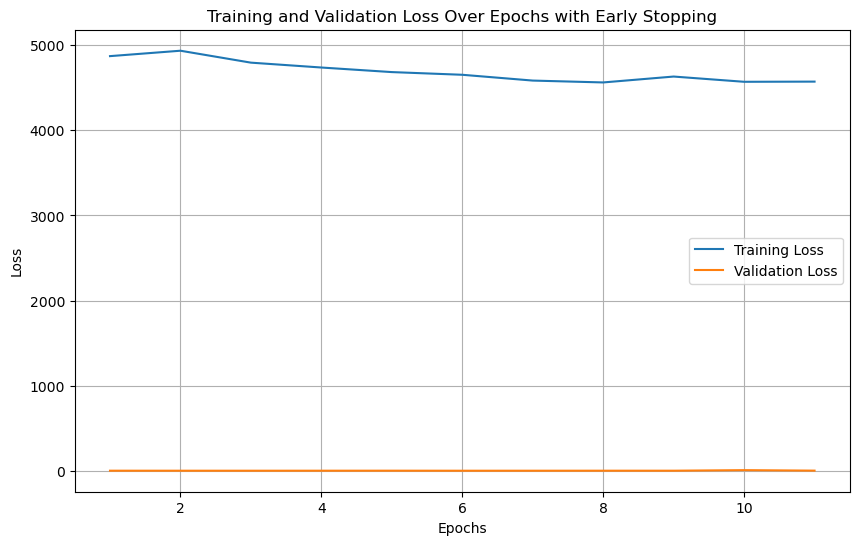

In [22]:
# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
min_delta = 0.001  # Minimum change in validation loss to qualify as an improvement
best_val_loss = float('inf')  # Initialize to a very large value
patience_counter = 0  # Counter for epochs without improvement

# Training the model with early stopping
train_losses = []
val_losses = []
early_stop = False

epochs = 50
batch_size = 32
for epoch in range(epochs):
    if early_stop:
        print("Early stopping triggered!")
        break

    model.train()
    epoch_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size].unsqueeze(1)

        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_validate).unsqueeze(1)
        val_loss = criterion(val_predictions, y_validate.unsqueeze(1))

    # Append losses for plotting
    train_losses.append(epoch_loss)
    val_losses.append(val_loss.item())
    
    #print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Logging progress
    logging.basicConfig(level=logging.INFO)
    logging.info(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Check for improvement
    if best_val_loss - val_loss.item() > min_delta:
        best_val_loss = val_loss.item()
        patience_counter = 0  # Reset the counter
    else:
        patience_counter += 1  # Increment the counter
        if patience_counter >= patience:
            early_stop = True

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs with Early Stopping')
plt.legend()
plt.grid()
plt.show()

# Test & External Validation Evaluation

In [23]:
# Test and external validation
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).squeeze().numpy()
    y_external_pred = model(X_external).squeeze().numpy()

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

external_mse = mean_squared_error(y_external, y_external_pred)
external_mae = mean_absolute_error(y_external, y_external_pred)
external_rmse = np.sqrt(external_mse)
external_r2 = r2_score(y_external, y_external_pred)

print(f"Test Set - MSE: {test_mse:.2f}, MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}")
print(f"External Validation - MSE: {external_mse:.2f}, MAE: {external_mae:.2f}, RMSE: {external_rmse:.2f}, R2: {external_r2:.2f}")

Test Set - MSE: 3.15, MAE: 1.27, RMSE: 1.78, R2: 0.38
External Validation - MSE: 5.18, MAE: 1.48, RMSE: 2.27, R2: -0.08


Test Set MSE: 3.1547
Test Set MAE: 1.2697
Test Set RMSE: 1.7762
Test Set R2: 37.5328
Test Set MSLE: 0.1616


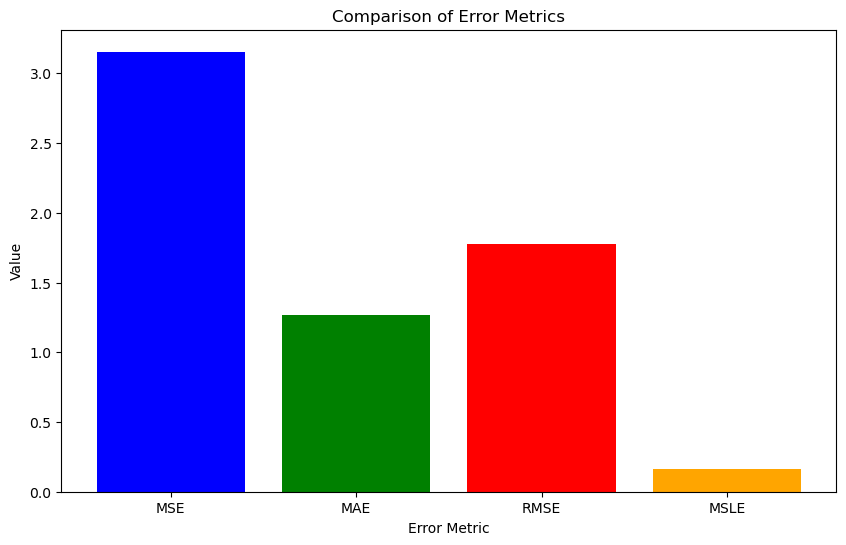

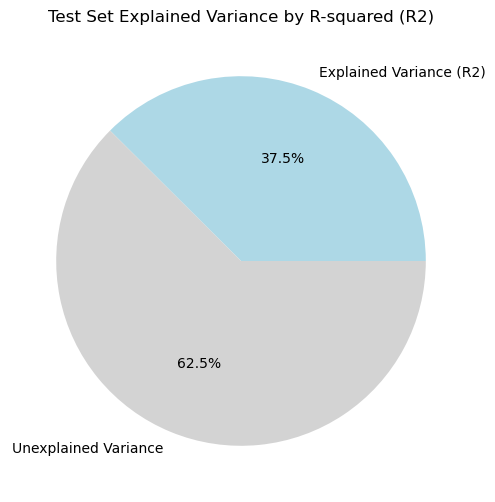

In [24]:
# Metrics calculation
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred) * 100

print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")
print(f"Test Set R2: {r2:.4f}")

# Initialize error metrics
error_metrics = ['MSE', 'MAE', 'RMSE']
values = [mse, mae, rmse]

# Try to calculate MSLE
try:
    msle = mean_squared_log_error(y_test, y_test_pred)
    print(f"Test Set MSLE: {msle:.4f}")
    
    # Add MSLE to the list of metrics if applicable
    error_metrics.append('MSLE')
    values.append(msle)
except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# Plot error metrics (with or without MSLE)
plt.figure(figsize=(10, 6))
plt.bar(error_metrics, values, color=['blue', 'green', 'red', 'orange'][:len(error_metrics)])
plt.xlabel('Error Metric')
plt.ylabel('Value')
plt.title('Comparison of Error Metrics')
plt.show()

# Plotting R-squared (R2) for the test set
plt.figure(figsize=(6, 6))

if r2 >= 0:
    plt.pie([r2, 100 - r2], 
            labels=['Explained Variance (R2)', 'Unexplained Variance'], 
            colors=['lightblue', 'lightgrey'], autopct='%1.1f%%')
else:
    plt.pie([100], labels=['Unexplained Variance'], colors=['lightgrey'], autopct='%1.1f%%')

plt.title('Test Set Explained Variance by R-squared (R2)')
plt.show()

External Validation Set MSE: 5.1755
External Validation Set MAE: 1.4805
External Validation Set RMSE: 2.2750
External Validation Set R2: -8.0320
Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.


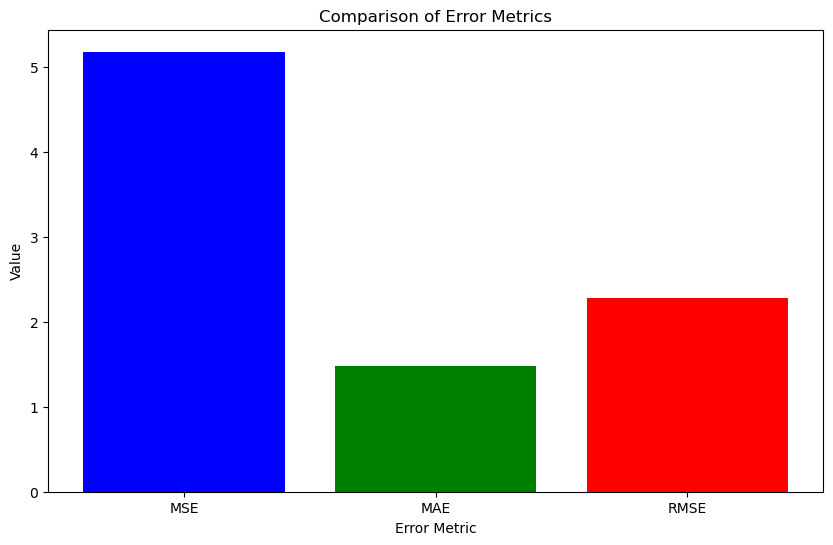

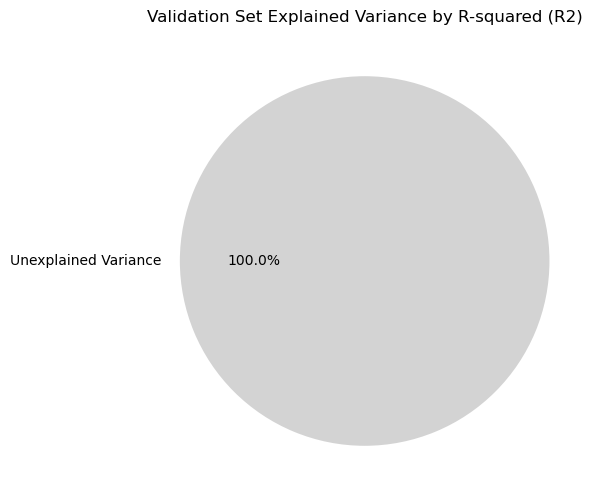

In [25]:
# Metrics for external validation set
mse_external = mean_squared_error(y_external, y_external_pred)
mae_external = mean_absolute_error(y_external, y_external_pred)
rmse_external = np.sqrt(mse_external)
r2_external = r2_score(y_external, y_external_pred) * 100

print(f"External Validation Set MSE: {mse_external:.4f}")
print(f"External Validation Set MAE: {mae_external:.4f}")
print(f"External Validation Set RMSE: {rmse_external:.4f}")
print(f"External Validation Set R2: {r2_external:.4f}")

# Initialize error metrics
error_metrics = ['MSE', 'MAE', 'RMSE']
values = [mse_external, mae_external, rmse_external]

# Try to calculate MSLE
try:
    msle_external = mean_squared_log_error(y_external, y_external_pred)
    print(f"External Validation Set MSLE: {msle_external:.4f}")
    
    # Add MSLE to the list of metrics if applicable
    error_metrics.append('MSLE')
    values.append(msle_external)
except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# Plot error metrics (with or without MSLE)
plt.figure(figsize=(10, 6))
plt.bar(error_metrics, values, color=['blue', 'green', 'red', 'orange'][:len(error_metrics)])
plt.xlabel('Error Metric')
plt.ylabel('Value')
plt.title('Comparison of Error Metrics')
plt.show()

# Plotting R-squared (R2) for the external validation set
plt.figure(figsize=(6, 6))

if r2_external >= 0:
    plt.pie([r2_external, 100 - r2_external], 
            labels=['Explained Variance (R2)', 'Unexplained Variance'], 
            colors=['lightblue', 'lightgrey'], autopct='%1.1f%%')
else:
    plt.pie([100], labels=['Unexplained Variance'], colors=['lightgrey'], autopct='%1.1f%%')

plt.title('Validation Set Explained Variance by R-squared (R2)')
plt.show()

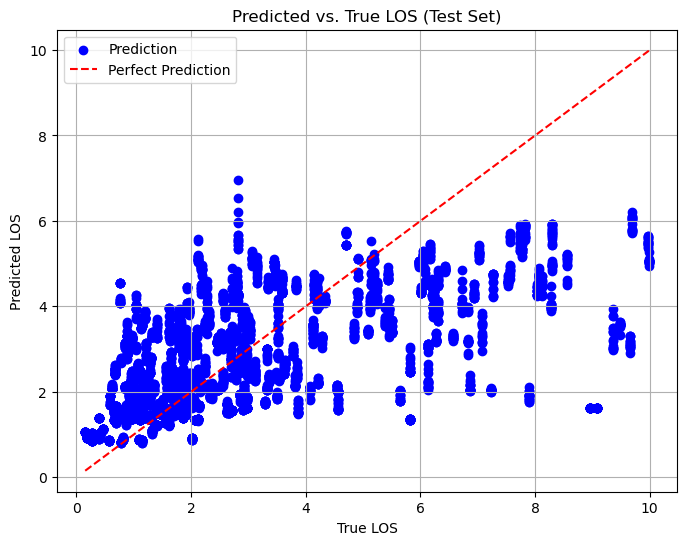

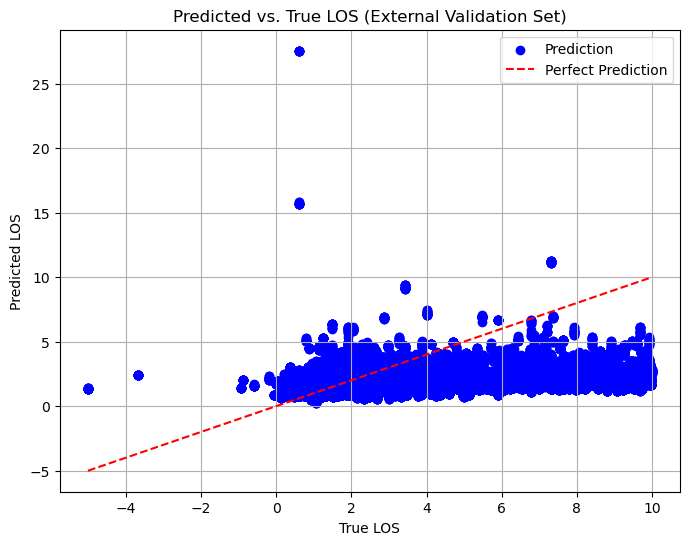

In [26]:
# Test Set Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Prediction')

# Line for Perfect Prediction
perfect_line = np.linspace(y_test.min(), y_test.max(), 100)
plt.plot(perfect_line, perfect_line, color='red', linestyle='--', label='Perfect Prediction')

# Labels, legend, and grid
plt.xlabel('True LOS')
plt.ylabel('Predicted LOS')
plt.legend()
plt.grid(True)
plt.title('Predicted vs. True LOS (Test Set)')

# Save the plot as a PNG image
#plt.savefig("plots/02_Prediction_Plot/02_true_vs_pred/57_true_vs_pred_test_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# External Validation Set Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_external, y_external_pred, color='blue', label='Prediction')

# Line for Perfect Prediction (y = x)
perfect_line_ext = np.linspace(y_external.min(), y_external.max(), 100)
plt.plot(perfect_line_ext, perfect_line_ext, color='red', linestyle='--', label='Perfect Prediction')

# Labels, legend, and grid
plt.xlabel('True LOS')
plt.ylabel('Predicted LOS')
plt.legend()
plt.grid(True)
plt.title('Predicted vs. True LOS (External Validation Set)')

# Save the plot as a PNG image
#plt.savefig("plots/02_Prediction_Plot/02_true_vs_pred/57_true_vs_pred_external_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Save model

In [27]:
# Define file
subfolder = "o01_feed_forward.pth"


torch.save(model.state_dict(), f"models/{subfolder}")

# Load model

In [ ]:
# Define file
subfolder = "o01_feed_forward.pth"

# Reinitialize the model architecture
input_dim = X_test.shape[1]  # Ensure this matches the original input dimension
model = ANNModel(input_dim)

# Load the saved model state
model.load_state_dict(torch.load(f"models/{subfolder}"))
model.eval()  # Set the model to evaluation mode

"""
After that I must run the block with layers.
Be careful, the layers must be exaclty the same. 
"""

# SHAP

In [ ]:
def model_predict(X):
    model.eval()
    with torch.no_grad():
        tensor_X = torch.tensor(X, dtype=torch.float32)
        predictions = model(tensor_X).numpy()
    return predictions

In [ ]:
# Convert tensors to Pandas DataFrames
X_sample_df = pd.DataFrame(X_sample_np, columns=[f"Feature_{i}" for i in range(X_sample_np.shape[1])])
X_validate_df = pd.DataFrame(X_validate_np, columns=[f"Feature_{i}" for i in range(X_validate_np.shape[1])])

# Use KernelExplainer with Pandas DataFrame
explainer = shap.KernelExplainer(model_predict, X_sample_df)
shap_values = explainer.shap_values(X_validate_df)

# Summary plot
shap.summary_plot(shap_values, X_validate_df)